In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
cuda = True if torch.cuda.is_available() else False

In [3]:
root = './data/'
batch_size = 128

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor()])

trainset = datasets.MNIST(root+'mnist/', train=True, 
                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                        batch_size=batch_size, 
                                        shuffle=True)

testset = datasets.MNIST(root+'mnist/', train=False, 
                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                        batch_size=batch_size, 
                                        shuffle=True)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [5]:
import matplotlib.pyplot as plt
import numpy as np

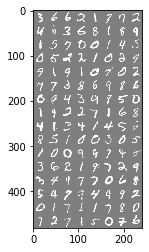

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import argparse

In [53]:
img_size = 28
# latent_dim = 62
# code_dim = 2
# n_classes = 10
channels = 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        input_dim = 28

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(input_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8), 
            nn.ReLU(inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        gen_input = x
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [54]:
net = Net() # Input size of MNIST dataset is 28

In [55]:
def CustomLoss(net, data, ref):
    # Calculate the divergence estimate using a neural network
    mean_f = net(data).mean()
    log_mean_ef_ref = torch.logsumexp(net(ref), 0) - np.log(ref.shape[0])
    return mean_f - log_mean_ef_ref

In [56]:
import torch.optim as optim

lr = 0.0001
b1 = 0.5
b2 = 0.999

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    net.parameters(), lr=lr, betas=(b1, b2)
)

In [57]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        print(inputs.shape)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

torch.Size([128, 1, 28, 28])


RuntimeError: running_mean should contain 1 elements not 128